In [66]:
# ICS 438 Final Project:
# Jerome Gallego, Taylor Wong, Ujjwal Gautam
# December 13, 2022
#
# For this project we have decided to use a dataset made from yelp reviews. 
# Using the operation known as Sentiment Analysis, we can provide a detailed investigation on whether or not the star ratings
# -can reflect how positive, negative, or neutral each review is.

# In the yelp dataset, we will only be analyzing the star ratings and the reviews itself. Everything else can be considered irrelevant

#For this notebook please install these packages to ensure that the file is running correctly
#%pip install -U gensim
#%pip install nltk


# Import whatever libraries you would want to use
# Clean up cells to put all imports to the top

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# import gensim
# from gensim.parsing.preprocessing import remove_stopwords
# import re

In [191]:
## Before we can do any kind of analysis we will need to load the dataset.
# As instructed, we understand that loading a file into ram can seem inefficient,
# to overcome this obstacle we have decided to process the data using the batching method that we have learned from Mahdi.

## Process yelp.csv with chunk size of 50 and append it to the dataframe


df = pd.DataFrame()
with open('./data/yelp.csv', "r+") as csv_file:
    tp = pd.read_csv(csv_file, iterator=True, chunksize=50)
    df = pd.concat(tp, ignore_index=True) 
# df.shape
# df.head()
# df['type'].describe
# df.info


In [192]:
columns = df.columns.values.tolist()
print(columns)
df['text'][0]

['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']


'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

In [193]:
## To ensure we have removed all the irrelevant columns, we used the function drop() which will tell
## the dataframe to only include the stars and the text review. 
df.drop(labels=["business_id", "date", "type", "review_id", "user_id", "cool", "useful", "funny"], axis=1, inplace=True)
df

,stars,text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...
...,...,...
9995,3,First visit...Had lunch here today - used my G...
9996,4,Should be called house of deliciousness!\n\nI ...
9997,4,I recently visited Olive and Ivy for business ...
9998,2,My nephew just moved to Scottsdale recently so...


In [194]:
## Cleaning the data
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import string
def clean_data(data):
    x = data.lower()
    x = x.replace('\n','')
    table = str.maketrans(dict.fromkeys(string.punctuation)) 
    x = x.translate(table)
    x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    return x

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [196]:
##apply clean_data function to the df["text"] column to remove punctuations, new lines, and stop words
df["text"] = df["text"].apply(clean_data)
df

,stars,text
0,5,wife took birthday breakfast excellent weathe...
1,5,idea people give bad reviews place goes show p...
2,4,love gyro plate rice good also dig candy selec...
3,5,rosie dakota love chaparral dog park convenien...
4,5,general manager scott petello good egg go deta...
...,...,...
9995,3,first visithad lunch today used groupon orde...
9996,4,called house deliciousnessi could go item item...
9997,4,recently visited olive ivy business last week ...
9998,2,nephew moved scottsdale recently bunch friends...


In [15]:
# As you can see there are 10000 entries in the file. By using Pandas Dataframe, it is good to know that we will not be able to
# -completely store all the data in RAM. With that being said to make it seem more realistic, we will cut down the dataframe
# -to have only 1000 randomly selected reviews. 
# Again, in some situations that can be too much for a machine to handle. To prevent any crashes or errors, we will be
# -batching the reviews in a set of 50 at a time.
# Thanks to the help of Assignment 2, we understand how to batch a set.

In [197]:
# # Using sample() will randomly select 1000 reviews for analysis
# df = df.sample(n=1000)
# df

In [17]:
# After we have cleaned the data to remove any sort of stop words and characters, we can start to implement the Sentiment Analysis.
# The main goal for this is produce a score from 0 to 1 whether it is categorized as Positive, Negative, or Neutral.

### Vader lexicon
Vader lexicon is a rule-based sentiment analysis tool specifically made for social media sentiment. For a more in-depth documentation please refer to their GitHub: https://github.com/cjhutto/vaderSentiment

### Why we chose vader lexicon
We decided to go with vader lexicon since the way vader lexicon was designed is meant for review analysis. On their GitHub page, examples of the training data used include 'The service here is extremely good', and 'The service here is good'. 

In [198]:
nltk.download('vader_lexicon') #WE NEED TO EXPLAIN WHAT THIS IS
from nltk.sentiment.vader import SentimentIntensityAnalyzer #WE NEED TO EXPLAIN WHAT THIS IS ALSO

for index, row in df['text'].iteritems():
    result = SentimentIntensityAnalyzer().polarity_scores(row)
    # if index%50 == 0:
    if result['neg'] > result['pos']:
        df.loc[index, "Sentiment"] = "negative"
    elif result['pos'] > result['neg']:
        df.loc[index, "Sentiment"] = "positive"
    else:
        df.loc[index, "Sentiment"] = "neutral"
        
    df.loc[index, 'neg'] = result['neg']
    df.loc[index, 'neu'] = result['neu']
    df.loc[index, 'pos'] = result['pos']
    df.loc[index, 'compound'] = result['compound']
df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,stars,text,Sentiment,neg,neu,pos,compound
0,5,wife took birthday breakfast excellent weathe...,positive,0.025,0.545,0.431,0.9935
1,5,idea people give bad reviews place goes show p...,positive,0.072,0.595,0.332,0.9901
2,4,love gyro plate rice good also dig candy selec...,positive,0.000,0.496,0.504,0.7964
3,5,rosie dakota love chaparral dog park convenien...,positive,0.000,0.713,0.287,0.9360
4,5,general manager scott petello good egg go deta...,positive,0.090,0.554,0.355,0.9304
...,...,...,...,...,...,...,...
9995,3,first visithad lunch today used groupon orde...,positive,0.000,0.794,0.206,0.9062
9996,4,called house deliciousnessi could go item item...,positive,0.150,0.498,0.352,0.9810
9997,4,recently visited olive ivy business last week ...,positive,0.055,0.639,0.307,0.9919
9998,2,nephew moved scottsdale recently bunch friends...,negative,0.236,0.663,0.101,-0.9186


In [199]:
low_rate = df[(df['stars'] == 1) | (df['stars'] == 2)]
low_rate

,stars,text,Sentiment,neg,neu,pos,compound
15,2,worth 21 salad small pizza absolutely bad serv...,negative,0.242,0.617,0.141,-0.8712
23,1,u go n check car u wanna buy 1 thats wrong mov...,negative,0.281,0.632,0.087,-0.9376
31,1,disgusting groupon daughter tried outdated g...,positive,0.148,0.473,0.378,0.8658
35,1,ive eaten many times none bad last nightservic...,positive,0.044,0.794,0.162,0.9445
56,2,add andrews reviewi cant believe things happen...,positive,0.095,0.736,0.169,0.9444
...,...,...,...,...,...,...,...
9954,2,stopped lunch bff todaynowhere park forced val...,positive,0.079,0.667,0.254,0.9917
9974,2,cowboy ciao best restaurant scottsdale cafe ca...,negative,0.256,0.573,0.172,-0.6108
9984,1,went last night whore foods get basics make pi...,negative,0.271,0.588,0.142,-0.9822
9987,1,food delicious service discriminatory barte...,positive,0.112,0.730,0.159,0.2732


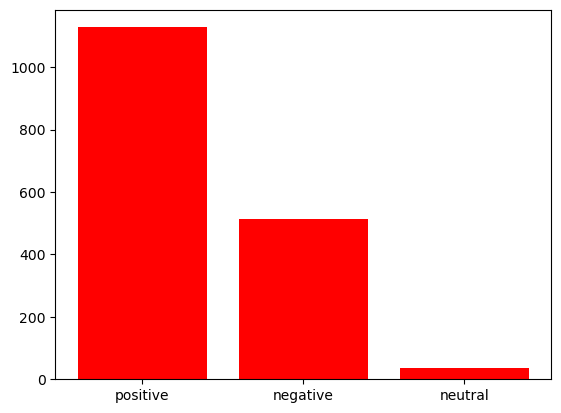

In [200]:
# bar chart showing total spread of sentiment
low_key = low_rate['Sentiment'].value_counts().keys().tolist()
low_val = low_rate['Sentiment'].value_counts().tolist()

fig = plt.bar(low_key, low_val, color='r')

([<matplotlib.patches.Wedge at 0x7fc0ff90abc0>,
 [Text(-0.5688442005726855, 0.9414968271188292, 'positive'),
  Text(0.5058450042125421, -0.9767910890836451, 'negative'),
  Text(1.0976297456762705, -0.07217299638123642, 'neutral')],
 [Text(-0.3102786548578284, 0.5135437238829976, '67.30%'),
  Text(0.27591545684320473, -0.53279513950017, '30.61%'),
  Text(0.5987071340052385, -0.03936708893521986, '2.09%')])

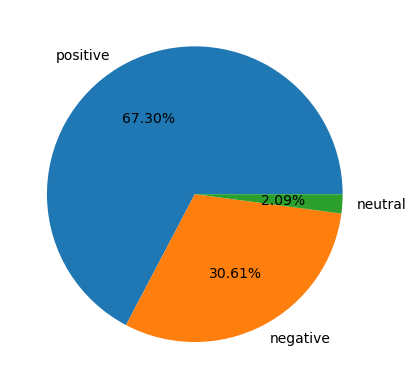

In [201]:
# normalize values to get %
norm_Lval = low_rate['Sentiment'].value_counts(normalize=True).tolist()
norm_Lvals = [i * 100 for i in norm_Lval]
for ind, i in enumerate(norm_Lvals):
    norm_Lvals[ind] = round(norm_Lvals[ind],2)
plt.pie(norm_Lvals, labels=low_key, autopct='%1.2f%%')

In [202]:
high_rate = df[(df['stars'] == 4) | (df['stars'] == 5)]
high_rate

,stars,text,Sentiment,neg,neu,pos,compound
0,5,wife took birthday breakfast excellent weathe...,positive,0.025,0.545,0.431,0.9935
1,5,idea people give bad reviews place goes show p...,positive,0.072,0.595,0.332,0.9901
2,4,love gyro plate rice good also dig candy selec...,positive,0.000,0.496,0.504,0.7964
3,5,rosie dakota love chaparral dog park convenien...,positive,0.000,0.713,0.287,0.9360
4,5,general manager scott petello good egg go deta...,positive,0.090,0.554,0.355,0.9304
...,...,...,...,...,...,...,...
9993,4,judging reviews maybe went good days ive enjoy...,positive,0.000,0.625,0.375,0.9638
9994,5,lets seewhat like surprise stadium well 950 ta...,positive,0.036,0.706,0.258,0.9946
9996,4,called house deliciousnessi could go item item...,positive,0.150,0.498,0.352,0.9810
9997,4,recently visited olive ivy business last week ...,positive,0.055,0.639,0.307,0.9919


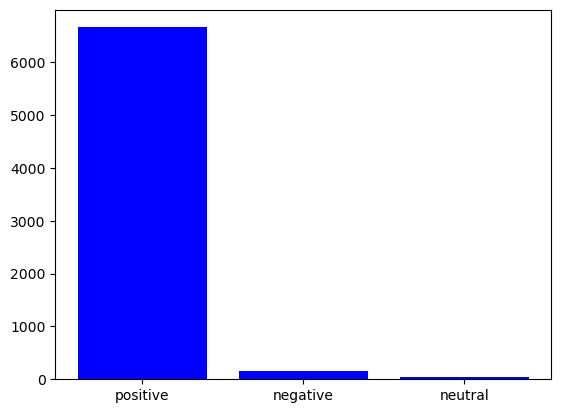

In [203]:
# bar chart showing total spread of sentiment
high_key = high_rate['Sentiment'].value_counts().keys().tolist()
high_val = high_rate['Sentiment'].value_counts().tolist()

fig = plt.bar(high_key, high_val, color='b')

([<matplotlib.patches.Wedge at 0x7fc1009f7e50>,
 [Text(-1.0954064953007396, 0.10042215917291718, 'positive'),
  Text(1.0929334338343943, -0.12448497582825038, 'negative'),
  Text(1.09973403406442, -0.02418789615484223, 'neutral')],
 [Text(-0.5974944519822216, 0.05477572318522755, '97.09%'),
  Text(0.596145509364215, -0.06790089590631838, '2.21%'),
  Text(0.5998549276715017, -0.013193397902641214, '0.70%')])

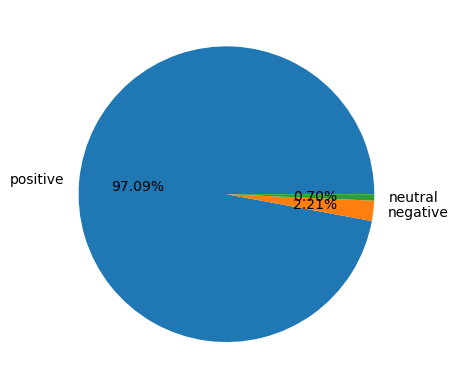

In [204]:
# normalize values to get %
norm_bval = high_rate['Sentiment'].value_counts(normalize=True).tolist()
norm_bvals = [i * 100 for i in norm_bval]
for ind, i in enumerate(norm_bvals):
    norm_bvals[ind] = round(norm_bvals[ind],2)
plt.pie(norm_bvals, labels=high_key, autopct='%1.2f%%')

In [205]:
neutral = df[(df['stars'] == 3)]
neutral

,stars,text,Sentiment,neg,neu,pos,compound
16,3,went saturday afternoon place incredibly empty...,negative,0.157,0.708,0.134,-0.4185
18,3,met friend lunch yesterday loved water feature...,positive,0.014,0.646,0.339,0.9904
20,3,dvapyou go least life really neat place alot h...,positive,0.031,0.722,0.246,0.9348
34,3,theres two ways look place one getting quality...,positive,0.144,0.710,0.146,0.0464
45,3,everything nice ice cream delicious overwhelmi...,positive,0.183,0.387,0.430,0.8225
...,...,...,...,...,...,...,...
9967,3,thought reviewed location already weird one ...,positive,0.123,0.659,0.218,0.6369
9968,3,never didnt know expect every time heard name...,positive,0.066,0.745,0.189,0.9675
9976,3,looking chile rellenos place great job making ...,positive,0.050,0.692,0.258,0.8720
9983,3,35 stars decided check place waves space decor...,positive,0.102,0.574,0.324,0.9765


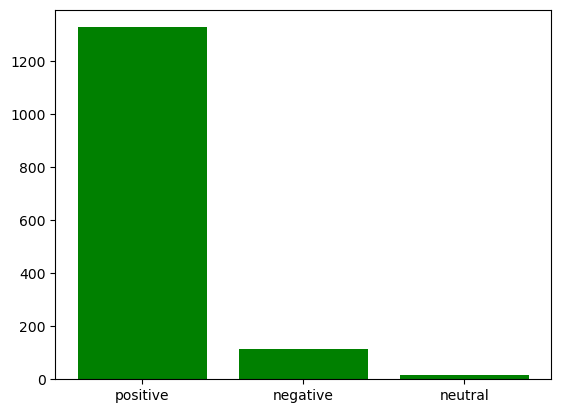

In [206]:
# bar chart showing total spread of sentiment
neu_key = neutral['Sentiment'].value_counts().keys().tolist()
neu_val = neutral['Sentiment'].value_counts().tolist()

fig = plt.bar(neu_key, neu_val, color='g')

([<matplotlib.patches.Wedge at 0x7fc1018c8b80>,
 [Text(-1.0560332674883537, 0.30788591711520535, 'positive'),
  Text(1.0433506075432801, -0.34845302371922166, 'negative'),
  Text(1.099178833517677, -0.04249578739968418, 'neutral')],
 [Text(-0.5760181459027384, 0.16793777297193016, '90.97%'),
  Text(0.5691003313872436, -0.19006528566502998, '7.80%'),
  Text(0.5995520910096419, -0.023179520399827735, '1.23%')])

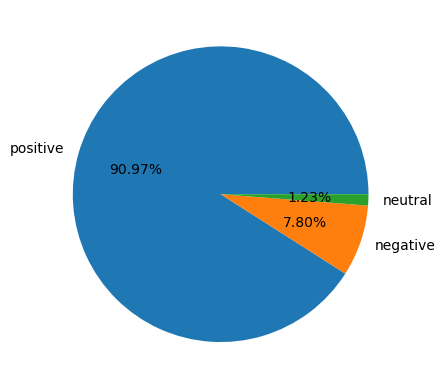

In [207]:
# normalize values to get %
norm_nval = neutral['Sentiment'].value_counts(normalize=True).tolist()
norm_nvals = [i * 100 for i in norm_nval]
for ind, i in enumerate(norm_nvals):
    norm_nvals[ind] = round(norm_nvals[ind],2)
plt.pie(norm_nvals, labels=neu_key, autopct='%1.2f%%')

## Part-2
   In this part of the project, we're using sentiment analysis of the user review to predict the ratings or stars they would give based on the review. We're using a train_test_split function provided by the scikit library to split the dataset into training and testing sets. We train our machine learning model with the training datasets and predict the result of the test dataset using the model.  

### Displaying the percentage distribution of stars in the dataset

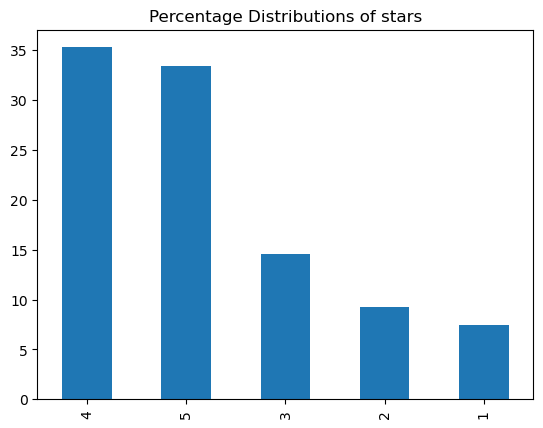

In [208]:
import matplotlib.pyplot as plt
round(df.stars.value_counts(normalize=True)*100,2).plot(kind='bar')
plt.title('Percentage Distributions of stars')
plt.show()

- As seen above our dataset contains a large number of 4 and 5 stars ratings.

## train_test_split
- we split the data into training and testing sets using train_test_split function

In [209]:
from sklearn.model_selection import train_test_split

independent_var = df.text
dependent_var = df.stars

IV_train, IV_test, DV_train, DV_test = train_test_split(independent_var, dependent_var, test_size = 0.1, random_state = 225)

print('Total number of train and test data')
print('independent_train :', len(IV_train))
print('independent_test  :', len(IV_test))
print('dependent_train :', len(DV_train))
print('dependent_test  :', len(DV_test))

Total number of train and test data
independent_train : 9000
independent_test  : 1000
dependent_train : 9000
dependent_test  : 1000


- We usedTfidfVectorizer class in the scikit-learn library to convert a collection of text reviews into a matrix of TF-IDF features. 
- We used logistic regression, a machine learning algorithm, to classify our reviews by training the model with the training dataset and predicting the outcome of the test datasets. 

In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tvec = TfidfVectorizer()
clf2 = LogisticRegression(solver = "lbfgs", max_iter=1000)


- We use Pipeline to preprocess, classify, and model our dataset

In [213]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
model = Pipeline([('vectorizer',tvec),('classifier',clf2)])

model.fit(IV_train, DV_train)
predictions = model.predict(IV_test)

confusion_matrix(predictions, DV_test)

array([[ 31,  14,   2,   3,   0],
       [ 11,  15,   7,   3,   3],
       [ 10,  18,  31,  14,   1],
       [ 15,  27,  77, 221, 101],
       [  7,  13,  25, 128, 223]])

- The below model predicts the stars that the user would give based on the review

In [220]:
# example = ["Extra bed was the worst breakfast queue was really terrible"]
# example =["excellent service, everything was perfect"]
# example =["Worst service, I'm unhappy"]
example =["The place was alright but it could've been better"]
result = model.predict(example)

print(result)

[3]


- Below is the accuracy, precision, and recall score of our model.

In [221]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy : ", accuracy_score(predictions, DV_test))
print("Precision : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy :  0.521
Precision :  0.5771786719910306
Recall :  0.521
